#Detección de anomalías: Ventas de un Supermercado

Alumno: Francisco Javier Castro Márquez

En este notebook se aplicarán 2 métodos de detección de anomalías con el fin de analizar cada uno de ellos y reconocer si alguno es más efectivo que otro. Los métodos usados son: 
Isolation Forest 

*   Isolation Forest 
*   Cluster-based Local Outlier Factor.

##Librerías necesarias:

In [27]:
!pip install pyod
!pip install combo

import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler


from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

##Dataset

Para este proyécto se utilizó el siguiente dataset obtenido en kaggle: https://www.kaggle.com/rohitsahoo/sales-forecasting

In [28]:
df = pd.read_csv("SampleSuperstore.csv")

In [30]:
df.head()

,Ship Mode,Segment,Country,City,State,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit
0,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Bookcases,261.9600,2,0.00,41.9136
1,Second Class,Consumer,United States,Henderson,Kentucky,42420,South,Furniture,Chairs,731.9400,3,0.00,219.5820
2,Second Class,Corporate,United States,Los Angeles,California,90036,West,Office Supplies,Labels,14.6200,2,0.00,6.8714
3,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Furniture,Tables,957.5775,5,0.45,-383.0310
4,Standard Class,Consumer,United States,Fort Lauderdale,Florida,33311,South,Office Supplies,Storage,22.3680,2,0.20,2.5164


Teniendo en cuenta que en este dataset se cuenta con información sobre las ventas en un supermercado, dos factores que son importantes considerar es el beneficio que se tiene en comparación de sus ventas.

In [31]:
df.Sales.describe()

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64

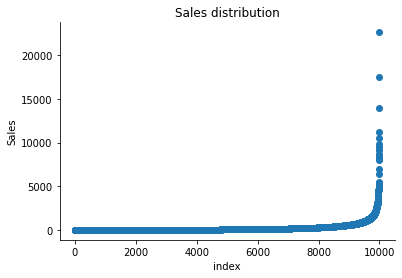

In [32]:
plt.scatter(range(df.shape[0]), np.sort(df['Sales'].values))
plt.xlabel('index')
plt.ylabel('Sales')
plt.title("Sales distribution")
sns.despine()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


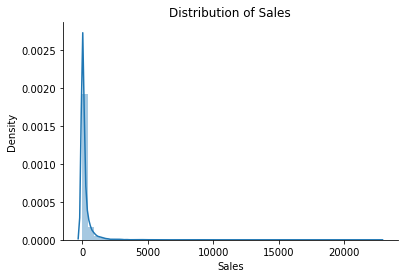

In [33]:
sns.distplot(df['Sales'])
plt.title("Distribution of Sales")
sns.despine()

La distribución de ventas del supermercado es muy diferente a una distribución normal, y tiene una cola larga y fina positiva, la masa de distribución se concentra en la izquierda, y su cola de distribución de ventas supera bastante a las colas de una distribución normal.

In [34]:
print("Skewness: %f" % df['Sales'].skew())
print("Kurtosis: %f" % df['Sales'].kurt())

Skewness: 12.972752
Kurtosis: 305.311753


In [35]:
df.Profit.describe()

count    9994.000000
mean       28.656896
std       234.260108
min     -6599.978000
25%         1.728750
50%         8.666500
75%        29.364000
max      8399.976000
Name: Profit, dtype: float64

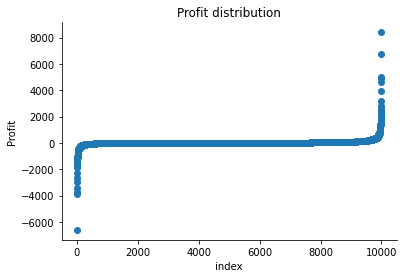

In [36]:
plt.scatter(range(df.shape[0]), np.sort(df['Profit'].values))
plt.xlabel('index')
plt.ylabel('Profit')
plt.title("Profit distribution")
sns.despine()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


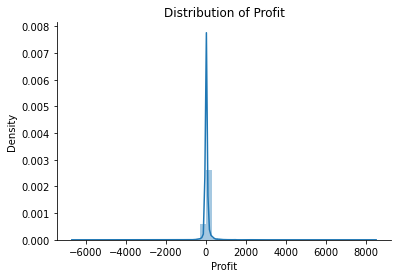

In [37]:
sns.distplot(df['Profit'])
plt.title("Distribution of Profit")
sns.despine()

In [38]:
print("Skewness: %f" % df['Profit'].skew())
print("Kurtosis: %f" % df['Profit'].kurt())

Skewness: 7.561432
Kurtosis: 397.188515


La districución de beneficios de la tienda tiene una cola positiva y una negativa, siendo más larga la cola negativa. Por lo tanto la distribución se encuentra sesgada positivamente y los datos tienen colas pesadas.

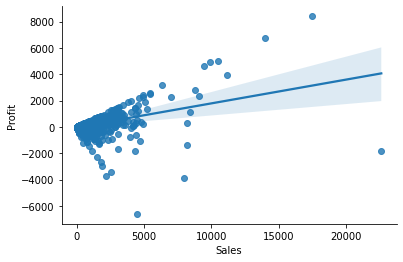

In [39]:
sns.regplot(x="Sales", y="Profit", data=df)
sns.despine();

En el gráfico de correlación anterior podemos observar que algunos de los puntos de datos son valores atipicos, los cuáles serian los valores extremadamente baos y extremadamente altos.

In [40]:
cols = ['Sales', 'Profit']
df[cols].head()

,Sales,Profit
0,261.9600,41.9136
1,731.9400,219.5820
2,14.6200,6.8714
3,957.5775,-383.0310
4,22.3680,2.5164


In [21]:
minmax = MinMaxScaler(feature_range=(0, 1))
df[['Sales','Profit']] = minmax.fit_transform(df[['Sales','Profit']])
df[['Sales','Profit']].head()

,Sales,Profit
0,0.011552,0.442794
1,0.032313,0.454639
2,0.000626,0.440458
3,0.042280,0.414464
4,0.000968,0.440168


In [22]:
X1 = df['Sales'].values.reshape(-1,1)
X2 = df['Profit'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

##Método: Isolation Forest
En este método, se realiza una partició de los datos mediante un conjunto de arboles, gracias a esto se proporciona una puntuación de anomalía que analiza el grado de aislamiento del punto en la estructura.

OUTLIERS:  100 INLIERS:  9894


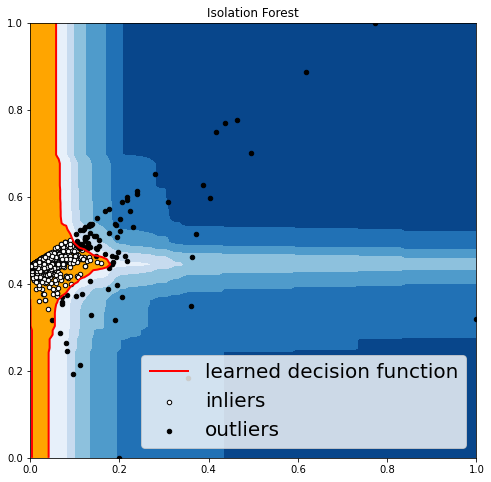

In [24]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IForest(contamination=outliers_fraction,random_state=0)
clf.fit(X)
scores_pred = clf.decision_function(X) * -1

y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)

threshold = percentile(scores_pred, 100 * outliers_fraction)
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

##Método: Cluster-based Local Outlier Factor
En este método se clasifican los datos en clusters pequeños y grandes. Su puntuación se calcula en función del tamaño del cluster al que pertenece el punto, asi como la distancia al cluster grande más cercano.

OUTLIERS: 100 INLIERS: 9894


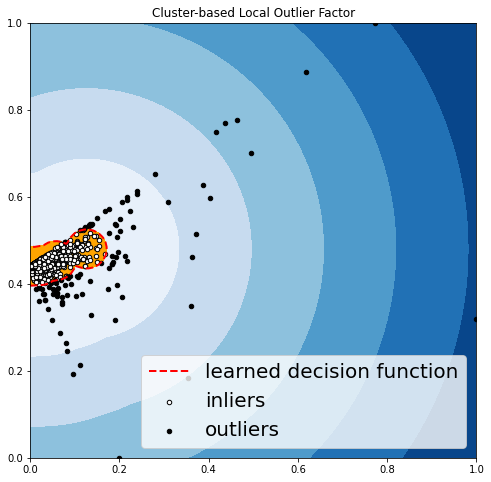

In [26]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)
clf.fit(X)
scores_pred = clf.decision_function(X) * -1
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
threshold = percentile(scores_pred, 100 * outliers_fraction)        
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor(CBLOF)')
plt.show();

#Bibliografía


*   https://www.youtube.com/watch?v=QPjG_313GOw&ab_channel=KarndeepSingh
*   https://www.youtube.com/watch?v=TP3wdwD8JVY&ab_channel=DecisionForest
*   https://www.kaggle.com/alaaalghmdi/superstore-sales
*   https://pyod.readthedocs.io/en/latest/



